Loading BokehJS ...

                                                                Strategy  \
Start                                          2020-01-01 00:00:00+00:00   
End                                            2020-09-08 00:00:00+00:00   
Duration                                               251 days 00:00:00   
Exposure Time [%]                                                88.0952   
Equity Final [$]                                                  144881   
Equity Peak [$]                                                   175200   
Equity Return [%]                                                44.8815   
Portfolio Mean daily Return [%]                                 0.197579   
Portfolio Risk (std dev) daily                                   3.21986   
Portfolio Return Annualized daily compounding                    105.536   
Portfolio Risk Annualized Daily std*sqrt(365)                    61.5154   
Simple Sharpe Ratio (no risk free)                                1.7156   
Buy & Hold R

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,27.47,2020-05-07,2020-07-21,NaT,NaN
1,25.97,2020-03-24,2020-04-22,2020-05-07,33
2,19.03,2020-02-14,2020-02-24,2020-03-12,20
3,7.33,2020-03-13,2020-03-16,2020-03-19,5
4,4.56,2020-03-20,2020-03-22,2020-03-23,2


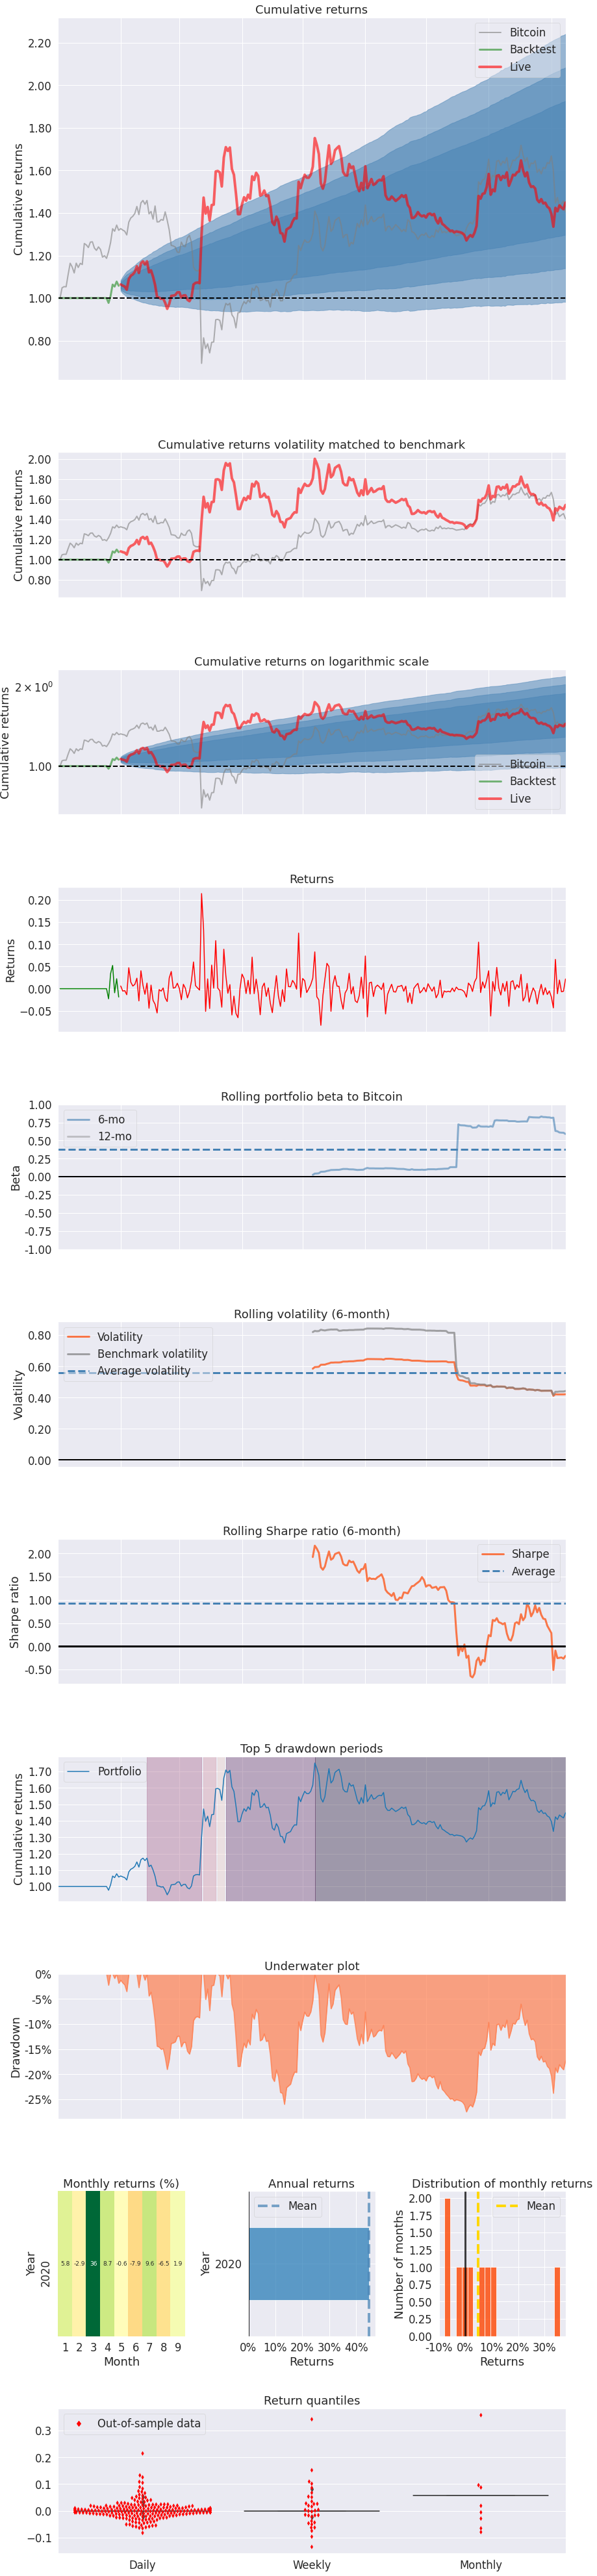

In [1]:
from operator import index
from backtesting import Backtest
from backtesting.test import GOOG
from backtesting.lib import resample_apply
from strategies import (
    Benchmark,
    SmaCross_w_sl,
    System,
    simpleSmaCross,
    eric,
    eric_ls,
    stacked_btc_fast,
)
import pandas as pd

import pyfolio as pf

# bt= Backtest(GOOG, SmaCross, commission=.002)
# -----------------------Read in Data-----------------#

# --------------Work PC ---------------#
df = pd.read_csv(
    r"<path_to>\full_btc_5min.csv",
    parse_dates=["datetime"],
    index_col="datetime",
)




# --------------Change Column Names to Match Backtest Package-----------#
bitcoin_5min = df.rename(
    columns={
        "price_open": "Open",
        "price_high": "High",
        "price_low": "Low",
        "price_close": "Close",
        "volume": "Volume",
    }
)
# --------------------Resample the 5 minute data ----------------------#
ohlc_dict = {
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum",
}
# Drop unnecessary columns
bitcoin_5min = bitcoin_5min[["Open", "High", "Low", "Close", "Volume"]]
bitcoin_daily = bitcoin_5min.resample("D", closed="left", label="left").apply(ohlc_dict)

in_sample = bitcoin_daily["2020"]
# ------------Calculate Statistics for benchmark Buy & Hold ------------------------ #
bm = Backtest(
    in_sample, Benchmark, margin=1, cash=100000, commission=0.0, exclusive_orders=True,
)
bm_stats = bm.run()  # create statistics for the benchmark


bt = Backtest(
    in_sample,
    eric_ls,
    margin=1,
    cash=100000,
    commission=0.002,
    exclusive_orders=True,
)
stats = bt.run()

# stats = bt.optimize(
#     n1=range(100, 200, 20),
#     n2=range(500, 5000, 500),
#     # maximize="Equity Final [$]",
#     maximize="Win Rate [%]",
#     # maximize='Sortino Ratio',
#     # constraint=lambda param: param.n1 < param.n2
# )
# print(stats["_strategy"])


# Create a dataframe to compare the strategy to the benchmark buy and hold
stats_numeric = stats.filter(regex="^[^_]")  # Skips objects _strategy, _trades, _equity
benchmark_stats_numeric = bm_stats.filter(regex="^[^_]")
difference = stats_numeric - benchmark_stats_numeric
# Combine the strategy, the benchmark, and difference data series into a single statistics df
df_stats = pd.concat([stats_numeric, benchmark_stats_numeric, difference], axis=1)
# Rename columns
df_stats.columns = ["Strategy", "Buy & Hold", "Difference"]
df_stats.to_csv(str(stats["_strategy"])+".csv")

print(df_stats)

strat_rets = stats._equity_curve["EquityPct"]
# print(strat_rets)
bm_rets = bm_stats._equity_curve["EquityPct"]
bm_rets.rename("Bitcoin", inplace=True)
strat_rets.dropna()
bm_rets.dropna()
pf.create_returns_tear_sheet(
    strat_rets,
    benchmark_rets=bm_rets,
    live_start_date="2020-02-01",
)
bt.plot()
